### Goal: Beat Andy and Emmanuel for ESL One Cologne fantasy league

I'd like to simulate the matchups across the tournament to determine a teams likilhood of winning the tournament. I having the most likely played out bracket, I will look at team matchups and see historically how players have performed in those matchups and also weight their performance against recent historicals for a team on a particular map. Essentially will choose the players that are predicted to perform the best (ADR-wise?) across the entire tourny.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import listdir
from os.path import join

import matplotlib.style as style
style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Player Level Analysis

In [2]:
path = '../data/master_players'
files = listdir(path)

# Import data
player_df = pd.DataFrame()
for file in files:
    file_df = pd.read_csv(os.path.join(path, file))
    player_df = player_df.append(file_df, ignore_index=True, sort=False)
    
# Convert unix time stamp to date time
player_df['date'] = player_df['date'] / 1000
player_df['date'] = pd.to_datetime(player_df['date'], unit ='s')
    
# Consider historical from 2018 to present
player_df = player_df.loc[player_df['date'] >= '2018-01-01 00:00:00', :]

# Keep only date
player_df['date'] = player_df['date'].dt.date

# Drop rows with NaN in KAST or ADR
player_df = player_df.loc[-player_df['KAST'].isna(), :]
player_df = player_df.loc[-player_df['ADR'].isna(), :]
player_df.reset_index(drop=True, inplace=True)
    
print(player_df.shape)
player_df.tail()

(256090, 20)


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
256085,79917,inf,2018-12-30,6503,CyberZen,180,Savage,12,8,5,0,17,77.3,-5,73.5,-3,0.98,0.55,0.77,0.66
256086,79918,mrg,2018-12-30,6503,CyberZen,839,tb,14,7,3,1,16,65.4,-2,65.7,-2,0.88,0.54,0.62,0.59
256087,79919,d2,2018-12-30,6503,CyberZen,839,tb,8,3,4,1,11,85.7,-3,43.3,-3,0.82,0.38,0.52,0.28
256088,79920,inf,2018-12-30,6503,CyberZen,7016,HZ,14,7,3,0,18,64.3,-4,50.9,-2,0.78,0.50,0.64,0.66
256089,79921,mrg,2018-12-30,6503,CyberZen,10168,bottle,10,5,4,1,9,77.8,1,59.7,1,1.13,0.56,0.50,0.92


To rank player performance I will consider how a particular player has played most recently and also consider how a player has matched up against a particular opponent.

Exponential Decay:
- y = a(1 - r)^x
- a = initial value (the amount before measuring growth or decay)
- r = growth or decay rate (most often represented as a percentage and expressed as a decimal)
- x = number of time intervals that have passed

#### Feature Engineering

In [3]:
# Number of days from today
current_datetime = pd.Timestamp('today').date()
player_df['days_from_today'] = (current_datetime - player_df['date']) / np.timedelta64(1, 'D')

# Exponential Decay from today
def exp_decay(days, a=1, r=0.03):
    '''
    @days: days from today
    @a: initial value
    @r: decay rate
    '''
    return a * (1 - r) ** days

player_df['decay'] = player_df['days_from_today'].apply(exp_decay)

# Normalize decay on a per player basis
player_df['normalized_decay'] = player_df['decay'] / player_df.groupby('player_id')['decay'].transform('sum')

player_df.head()

,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact,days_from_today,decay,normalized_decay
0,79922,inf,2019-01-04,8248,PACT,16847,mhL,18,9,1,0,16,63.0,2,74.5,4,1.14,0.67,0.59,1.41,190.0,0.003066,0.020712
1,79923,mrg,2019-01-04,8248,PACT,16847,mhL,19,12,4,0,17,64.0,2,79.6,-2,1.08,0.76,0.68,1.05,190.0,0.003066,0.020712
2,79924,d2,2019-01-04,7535,ROG SPUNJ,11789,Misfit,15,6,3,1,17,58.3,-2,70.1,0,0.94,0.62,0.71,0.99,190.0,0.003066,0.324556
3,79925,mrg,2019-01-04,9791,ROG pronax,17082,Ex6poN,21,9,1,0,19,65.4,2,71.0,0,1.09,0.81,0.73,1.30,190.0,0.003066,0.244233
4,79926,cch,2019-01-04,8695,ROG nooky,18457,s1las,20,11,5,0,20,79.2,0,91.4,1,1.17,0.83,0.83,1.10,190.0,0.003066,0.162479


In [4]:
# Aggregation on features with exponential decay to get current state of player
def player_features_normalized(stuff):
    new_df = pd.DataFrame()
    new_df['map_id'] = stuff['map_id']
    new_df['map'] = stuff['map']
    new_df['team_id'] = stuff['team_id']
    new_df['team_name'] = stuff['team_name']
    new_df['player_id'] = stuff['player_id']
    new_df['player_name'] = stuff['player_name']
    
    
    # Normalize features of interest
    columns = ['kills', 'assists', 'deaths', 'ADR', 'rating']
    for column in columns:
        new_df[column] = stuff[column] * stuff['normalized_decay']
    
    return new_df

player_norm_df = player_features_normalized(player_df)
player_norm_df.head()

,map_id,map,team_id,team_name,player_id,player_name,kills,assists,deaths,ADR,rating
0,79922,inf,8248,PACT,16847,mhL,0.372815,0.020712,0.331391,1.543040,0.023612
1,79923,mrg,8248,PACT,16847,mhL,0.393527,0.082848,0.352103,1.648671,0.022369
2,79924,d2,7535,ROG SPUNJ,11789,Misfit,4.868334,0.973667,5.517446,22.751350,0.305082
3,79925,mrg,9791,ROG pronax,17082,Ex6poN,5.128893,0.244233,4.640427,17.340542,0.266214
4,79926,cch,8695,ROG nooky,18457,s1las,3.249581,0.812395,3.249581,14.850586,0.190101


So from these normalized features, I would like to create a custom player score to rank the best players.

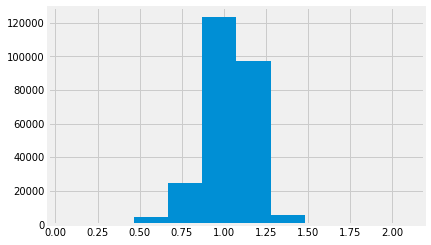

In [5]:
# Create 'true' features counts (sum up a feature)
player_norm_df['true_kills'] = player_norm_df.groupby('player_id')['kills'].transform('sum')
player_norm_df['true_assists'] = player_norm_df.groupby('player_id')['assists'].transform('sum')
player_norm_df['true_deaths'] = player_norm_df.groupby('player_id')['deaths'].transform('sum')
player_norm_df['true_ADR'] = player_norm_df.groupby('player_id')['ADR'].transform('sum')
player_norm_df['true_rating'] = player_norm_df.groupby('player_id')['rating'].transform('sum')
player_norm_df['true_rating'].hist()
plt.show()

In [6]:
# Collect only the player and their 'true' features
true_player_df = player_norm_df.drop(columns=['map_id', 'map', 'kills', 'assists', 'deaths', 'ADR', 'rating']).drop_duplicates()
print(true_player_df.shape)
true_player_df.head()

(13751, 9)


,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
0,8248,PACT,16847,mhL,10.382967,2.301226,20.153995,50.379149,0.578057
2,7535,ROG SPUNJ,11789,Misfit,13.635393,1.994288,16.666406,63.325690,0.891901
3,9791,ROG pronax,17082,Ex6poN,17.221979,3.268116,17.239530,70.496142,1.019378
4,8695,ROG nooky,18457,s1las,15.812395,5.000000,17.654941,68.485427,1.039347
5,7538,ROG fl0m,8503,fl0m,16.133416,4.517028,17.655834,70.443003,0.969120


### BLAST PRO SERIES LOS ANGELES - RANKING PLAYERS

So just as a review, we are looking at players weighted average kills, assists, deaths, and ADR from the past year. This was determined by exponentially decaying on their performanes. Essentially giving more weight to recent games than older games. From these features, I hope to be able to rank players reasonably well and also optimize against the fantasy leagues constraints (max: 1,000,000 USD team composition, player values [ex: 'Stewie2K' = 202,000 USD])

In [7]:
team_names = ['Liquid', 'NRG', 'FaZe', 'MIBR','Renegades', 'Cloud9']

esl_one_players = true_player_df.loc[true_player_df['team_name'].isin(team_names), :]
print(esl_one_players.shape)
esl_one_players.head()

(65, 9)


,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
325,5973,Liquid,8738,EliGE,21.409767,4.786286,17.421776,87.027727,1.268044
328,6667,FaZe,3741,NiKo,20.054218,4.934668,18.592400,81.379690,1.121721
335,5752,Cloud9,3055,flusha,18.506819,6.531516,17.060731,84.212925,1.116471
346,5973,Liquid,8520,NAF,18.830216,5.742831,16.600831,81.906497,1.192509
352,5973,Liquid,10394,Twistzz,19.150346,3.882184,15.807924,73.379977,1.158764


In [8]:
esl_one_players.sort_values(['true_rating'], ascending=False)

,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
77601,6211,Renegades,8771,USTILO,20.160830,3.122224,11.014763,96.231295,1.463945
4599,6667,FaZe,8771,USTILO,20.160830,3.122224,11.014763,96.231295,1.463945
325,5973,Liquid,8738,EliGE,21.409767,4.786286,17.421776,87.027727,1.268044
3921,6211,Renegades,11271,smooya,22.126674,5.607842,16.273750,81.741850,1.247459
380,6673,NRG,9136,Brehze,21.034381,3.746421,17.206452,83.239038,1.225864
441,6211,Renegades,4679,jks,19.853696,4.638663,17.030824,84.666560,1.214457
76357,6211,Renegades,8520,NAF,18.830216,5.742831,16.600831,81.906497,1.192509
346,5973,Liquid,8520,NAF,18.830216,5.742831,16.600831,81.906497,1.192509
1897,9215,MIBR,2023,FalleN,18.735108,4.664038,15.918451,76.258643,1.192156
390,6673,NRG,10671,Ethan,18.745023,5.977541,17.627723,82.612606,1.183055


I have chosen my team by looking at players who on HLTV have aggregate ADR that are less than that of my 'true_ADR' feature. My team given this approach:
- yuurih (FURIA)
- VINI (FURIA)
- XANTARES (BIG)
- blameF (heroic)
- device (Astralis).

### Considerations only data where teams have played each other

In [9]:
path = '../data/master_players'
files = listdir(path)

# Import data
player_df = pd.DataFrame()
for file in files:
    file_df = pd.read_csv(os.path.join(path, file))
    player_df = player_df.append(file_df, ignore_index=True, sort=False)
    
# Convert unix time stamp to date time
player_df['date'] = player_df['date'] / 1000
player_df['date'] = pd.to_datetime(player_df['date'], unit ='s')
    
# Consider historical from 2018 to present
player_df = player_df.loc[player_df['date'] >= '2018-01-01 00:00:00', :]

# Keep only date
player_df['date'] = player_df['date'].dt.date

# Drop rows with NaN in KAST or ADR
player_df = player_df.loc[-player_df['KAST'].isna(), :]
player_df = player_df.loc[-player_df['ADR'].isna(), :]
player_df.reset_index(drop=True, inplace=True)
    
print(player_df.shape)
player_df.tail()

(256090, 20)


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
256085,79917,inf,2018-12-30,6503,CyberZen,180,Savage,12,8,5,0,17,77.3,-5,73.5,-3,0.98,0.55,0.77,0.66
256086,79918,mrg,2018-12-30,6503,CyberZen,839,tb,14,7,3,1,16,65.4,-2,65.7,-2,0.88,0.54,0.62,0.59
256087,79919,d2,2018-12-30,6503,CyberZen,839,tb,8,3,4,1,11,85.7,-3,43.3,-3,0.82,0.38,0.52,0.28
256088,79920,inf,2018-12-30,6503,CyberZen,7016,HZ,14,7,3,0,18,64.3,-4,50.9,-2,0.78,0.50,0.64,0.66
256089,79921,mrg,2018-12-30,6503,CyberZen,10168,bottle,10,5,4,1,9,77.8,1,59.7,1,1.13,0.56,0.50,0.92


In [10]:
# Subset dataframe by maps where only the teams in the tournament have played each other
team_names = ['Liquid', 'NRG', 'FaZe', 'MIBR','Renegades', 'Cloud9']

# Only data from the teams of interest
player_df = player_df.loc[player_df['team_name'].isin(team_names),:]

# Find map_ids that are shared between teams
shared_ids = []
all_ids = []
for team in team_names:
    team_df = player_df.loc[player_df['team_name'] == team, :]
    map_ids = list(team_df['map_id'].unique())

    # Check if map_id has already been collected
    for map_id in map_ids:
        if map_id in all_ids:
            shared_ids.append(map_id)
            
    all_ids = all_ids + list(map_ids)
    
print('Number of matches between all teams:', len(shared_ids))

# Collect only matches between teams in the tourny
player_df = player_df.loc[player_df['map_id'].isin(shared_ids),:]
player_df.head()

Number of matches between all teams: 240


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
489,80463,ovp,2019-01-25,6667,FaZe,334,AdreN,28,11,6,3,24,73.5,4,80.9,-1,1.13,0.82,0.71,0.97
492,80467,mrg,2019-01-25,6667,FaZe,2757,GuardiaN,28,6,8,5,18,71.4,10,77.7,5,1.26,0.80,0.51,1.29
566,80549,mrg,2019-01-27,5752,Cloud9,8735,autimatic,22,5,4,2,7,89.5,15,93.9,3,1.80,1.16,0.37,2.00
567,80550,inf,2019-01-27,5752,Cloud9,3055,flusha,23,7,9,2,19,71.4,4,97.2,2,1.24,0.82,0.68,1.23
568,80551,trn,2019-01-27,5752,Cloud9,7805,RUSH,16,5,4,0,17,68.0,-1,75.6,5,1.07,0.64,0.68,1.37


In [11]:
# Number of days from today
current_datetime = pd.Timestamp('today').date()
player_df['days_from_today'] = (current_datetime - player_df['date']) / np.timedelta64(1, 'D')

# Exponential Decay from today
def exp_decay(days, a=1, r=0.03):
    '''
    @days: days from today
    @a: initial value
    @r: decay rate
    '''
    return a * (1 - r) ** days

player_df['decay'] = player_df['days_from_today'].apply(exp_decay)

# Normalize decay on a per player basis
player_df['normalized_decay'] = player_df['decay'] / player_df.groupby('player_id')['decay'].transform('sum')

player_df.head()

,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact,days_from_today,decay,normalized_decay
489,80463,ovp,2019-01-25,6667,FaZe,334,AdreN,28,11,6,3,24,73.5,4,80.9,-1,1.13,0.82,0.71,0.97,169.0,0.005813,0.007334
492,80467,mrg,2019-01-25,6667,FaZe,2757,GuardiaN,28,6,8,5,18,71.4,10,77.7,5,1.26,0.80,0.51,1.29,169.0,0.005813,0.003664
566,80549,mrg,2019-01-27,5752,Cloud9,8735,autimatic,22,5,4,2,7,89.5,15,93.9,3,1.80,1.16,0.37,2.00,167.0,0.006178,0.003864
567,80550,inf,2019-01-27,5752,Cloud9,3055,flusha,23,7,9,2,19,71.4,4,97.2,2,1.24,0.82,0.68,1.23,167.0,0.006178,0.075803
568,80551,trn,2019-01-27,5752,Cloud9,7805,RUSH,16,5,4,0,17,68.0,-1,75.6,5,1.07,0.64,0.68,1.37,167.0,0.006178,0.003864


In [12]:
# Aggregation on features with exponential decay to get current state of player
def player_features_normalized(stuff):
    new_df = pd.DataFrame()
    new_df['map_id'] = stuff['map_id']
    new_df['map'] = stuff['map']
    new_df['team_id'] = stuff['team_id']
    new_df['team_name'] = stuff['team_name']
    new_df['player_id'] = stuff['player_id']
    new_df['player_name'] = stuff['player_name']
    
    
    # Normalize features of interest
    columns = ['kills', 'assists', 'deaths', 'ADR', 'rating']
    for column in columns:
        new_df[column] = stuff[column] * stuff['normalized_decay']
    
    return new_df

player_norm_df = player_features_normalized(player_df)
player_norm_df.head()

,map_id,map,team_id,team_name,player_id,player_name,kills,assists,deaths,ADR,rating
489,80463,ovp,6667,FaZe,334,AdreN,0.205355,0.044005,0.176019,0.593330,0.008288
492,80467,mrg,6667,FaZe,2757,GuardiaN,0.102588,0.029311,0.065950,0.284682,0.004616
566,80549,mrg,5752,Cloud9,8735,autimatic,0.085000,0.015455,0.027045,0.362795,0.006955
567,80550,inf,5752,Cloud9,3055,flusha,1.743476,0.682230,1.440262,7.368080,0.093996
568,80551,trn,5752,Cloud9,7805,RUSH,0.061818,0.015455,0.065682,0.292091,0.004134


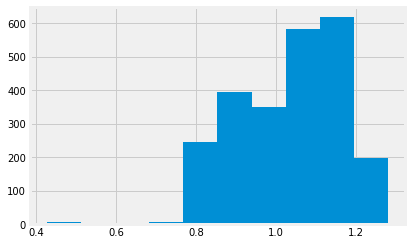

In [13]:
# Create 'true' features counts (sum up a feature)
player_norm_df['true_kills'] = player_norm_df.groupby('player_id')['kills'].transform('sum')
player_norm_df['true_assists'] = player_norm_df.groupby('player_id')['assists'].transform('sum')
player_norm_df['true_deaths'] = player_norm_df.groupby('player_id')['deaths'].transform('sum')
player_norm_df['true_ADR'] = player_norm_df.groupby('player_id')['ADR'].transform('sum')
player_norm_df['true_rating'] = player_norm_df.groupby('player_id')['rating'].transform('sum')
player_norm_df['true_rating'].hist()
plt.show()

In [14]:
# Collect only the player and their 'true' features
true_player_df = player_norm_df.drop(columns=['map_id', 'map', 'kills', 'assists', 'deaths', 'ADR', 'rating']).drop_duplicates()
print(true_player_df.shape)
true_player_df.head()

(59, 9)


,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
489,6667,FaZe,334,AdreN,15.497653,3.678528,17.424904,63.895906,0.941989
492,6667,FaZe,2757,GuardiaN,19.334342,4.847792,19.726960,69.541724,1.000295
566,5752,Cloud9,8735,autimatic,14.218692,4.763387,17.695390,70.817717,0.904256
567,5752,Cloud9,3055,flusha,18.030219,6.394485,17.629023,82.337430,1.088105
568,5752,Cloud9,7805,RUSH,11.863015,2.869465,18.165871,59.500824,0.774686


In [15]:
# Rank by rating
true_player_df.sort_values(['true_rating'], ascending=False).reset_index(drop=True)

,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
0,5973,Liquid,8738,EliGE,21.961880,4.806387,17.875892,88.450404,1.280597
1,6673,NRG,10671,Ethan,19.704042,5.663636,17.240823,88.905652,1.202356
2,5752,Cloud9,10610,refrezh,23.000000,4.000000,17.500000,76.750000,1.185000
3,5973,Liquid,8346,jdm64,18.936332,3.540608,18.759282,78.610184,1.177317
4,6667,FaZe,3741,NiKo,22.030747,6.814648,20.501805,84.650879,1.170809
5,6673,NRG,11219,CeRq,18.004075,4.312452,15.046826,72.282158,1.164213
6,6673,NRG,9136,Brehze,19.010709,3.462704,16.510644,78.122651,1.156890
7,9215,MIBR,2023,FalleN,17.557782,5.221525,14.992912,72.791777,1.151623
8,6667,FaZe,8183,rain,21.813609,5.899130,21.198437,82.233014,1.145262
9,6673,NRG,8523,tarik,17.693784,4.800466,17.128354,77.898803,1.130182


### ESL ONE COLOGNE Bracket

<div align="center"><img src="../images/ESL One Cologne-Group A.png" style="width:500px;height:300px"> <img src="../images/ESL One Cologne-Group B.png" style="width:500px;height:300px"></div>

<img src="../images/ESL One Cologne-Teams.png" class="center" style="width:600px;height:600px">

Top teams from each upper bracket advances to semi-finals. The losers of the upper bracket finals play in the quarterfinals. Top teams from each lower bracket advances to quarterfinals. Teams that lose in the first round player teams from the same side of their bracket in the lower bracket. Teams in the upper bracket that lose in the second round play on the opposite side of the lower bracket. All teams starting on a particular upper bracket will only play teams of the bracket until the playoffs (quarters/semis).

## Post Analysis

Fantasy system uses an average of a players pts when that player does not play during a particular round. This means that if your player bows out early, whatever their average pts was across the rounds that they played, gets added to your total score on each of the subsequent rounds. If one of your players advances and does not have to play a round (advances to the finals of the upper bracket and makes it directly to the semis), they also carry their average across those non-played rounds. **All in all, this means that you want to choose players that will make the semi's directly because you are more likely to be guaranteed points with less variation.**

I'll simulate the tournament next time to get the most likely outcomes for the tournament and prioritize players that are on teams that are likely to make the upper bracket finals and/or the semis. I will also take the final ratings of each player from the tourny to create a dataset to train on the final ratings given pre-match aggregate features.

I need to make sure to version my data.